In [1]:
# Params
input_size = (299,299)
batch_size = 100
num_workers = 8
num_classes = 2
learning_rate = 1e-03
epochs = 100

In [2]:
import torch

print("torch-version:", torch.__version__)
print("Available GPU:", torch.cuda.current_device())

torch-version: 1.1.0
Available GPU: 0


In [3]:
from load_MH import *

# 기존 데이터 경로
NORMAL_DIR = '../../snapshots_pureok'
FAULT_DIR = '../../snapshots'
# 추가 데이터 경로
ADD_NORMAL_DIR = '../../snapshots_punch181'
ADD_FAULT_DIR = '../../snapshots_punch181_NG'

train_mhdb = dataset(NORMAL_DIR, FAULT_DIR, ADD_NORMAL_DIR, ADD_FAULT_DIR, input_size, batch_size, num_workers)[:4]
val_mhdb = dataset(NORMAL_DIR, FAULT_DIR, ADD_NORMAL_DIR, ADD_FAULT_DIR, input_size, batch_size, num_workers)[4:8]
test_mhdb = dataset(NORMAL_DIR, FAULT_DIR, ADD_NORMAL_DIR, ADD_FAULT_DIR, input_size, batch_size, num_workers)[8:]

In [4]:
import torchvision
print("torchvision-version:", torchvision.__version__)

net = torchvision.models.inception_v3(pretrained=False, aux_logits=True, num_classes=num_classes).cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

torchvision-version: 0.2.2


In [5]:
def validation(dataset, model, criterion):
    
    with torch.no_grad():
        model.eval()
        running_loss = 0.0
        for data in dataset:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda().long()

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            
    return running_loss

In [6]:
import numpy as np

times = 1
aux_loss_weight = 0.4
all_train_loss = []
all_val_loss = []
row = np.arange(epochs)

for epoch in range(epochs):  # loop over the dataset multiple times
    net.train()
    running_loss = 0.0
    for i, data in enumerate(train_mhdb[1]):
        # get the inputs
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda().long()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, aux_outputs = net(inputs) #tuple: (x, aux)
        
        loss1 = criterion(outputs, labels)
        loss2 = criterion(aux_outputs, labels)
        
        loss = loss1 + aux_loss_weight*loss2
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    if epoch % times == 0:
        print("Epoch:", epoch)
        print("Train Loss:", running_loss / times)
        val_loss = validation(val_mhdb[1], net, criterion)
        print("Val Loss:", val_loss)
        
        name = "CAM2"+"-Epoch-"+"%s"%epoch+"-Loss-"+"%s"%str(val_loss)[:8]+".pth"
        model_path = './saved_models/' + name
        torch.save(net.state_dict(), model_path)
        print("Saved model:", model_path, "\n")
        
        all_train_loss.append(running_loss)
        all_val_loss.append(val_loss)
        running_loss = 0.0

print('\nFinished Training')

Epoch: 0
Train Loss: 35.54990243911743
Val Loss: 5.9185872077941895
Saved model: ./saved_models/CAM2-Epoch-0-Loss-5.918587.pth 

Epoch: 1
Train Loss: 29.68480098247528
Val Loss: 3.6926928758621216
Saved model: ./saved_models/CAM2-Epoch-1-Loss-3.692692.pth 

Epoch: 2
Train Loss: 21.934894680976868
Val Loss: 2.724963426589966
Saved model: ./saved_models/CAM2-Epoch-2-Loss-2.724963.pth 

Epoch: 3
Train Loss: 18.960103571414948
Val Loss: 3.0045209527015686
Saved model: ./saved_models/CAM2-Epoch-3-Loss-3.004520.pth 

Epoch: 4
Train Loss: 15.965102732181549
Val Loss: 1.7166495770215988
Saved model: ./saved_models/CAM2-Epoch-4-Loss-1.716649.pth 

Epoch: 5
Train Loss: 14.091320127248764
Val Loss: 1.7211455702781677
Saved model: ./saved_models/CAM2-Epoch-5-Loss-1.721145.pth 

Epoch: 6
Train Loss: 12.741957306861877
Val Loss: 1.5453419238328934
Saved model: ./saved_models/CAM2-Epoch-6-Loss-1.545341.pth 

Epoch: 7
Train Loss: 13.13560938835144
Val Loss: 1.311227485537529
Saved model: ./saved_model

Epoch: 63
Train Loss: 5.310591883957386
Val Loss: 1.234344333410263
Saved model: ./saved_models/CAM2-Epoch-63-Loss-1.234344.pth 

Epoch: 64
Train Loss: 5.591267094016075
Val Loss: 1.3277373164892197
Saved model: ./saved_models/CAM2-Epoch-64-Loss-1.327737.pth 

Epoch: 65
Train Loss: 5.793615862727165
Val Loss: 1.192209616303444
Saved model: ./saved_models/CAM2-Epoch-65-Loss-1.192209.pth 

Epoch: 66
Train Loss: 5.076509915292263
Val Loss: 1.1918954476714134
Saved model: ./saved_models/CAM2-Epoch-66-Loss-1.191895.pth 

Epoch: 67
Train Loss: 4.664810121059418
Val Loss: 1.3777414858341217
Saved model: ./saved_models/CAM2-Epoch-67-Loss-1.377741.pth 

Epoch: 68
Train Loss: 5.454553663730621
Val Loss: 1.2610985040664673
Saved model: ./saved_models/CAM2-Epoch-68-Loss-1.261098.pth 

Epoch: 69
Train Loss: 5.541338510811329
Val Loss: 1.6664895117282867
Saved model: ./saved_models/CAM2-Epoch-69-Loss-1.666489.pth 

Epoch: 70
Train Loss: 5.318158224225044
Val Loss: 1.2935123145580292
Saved model: ./s

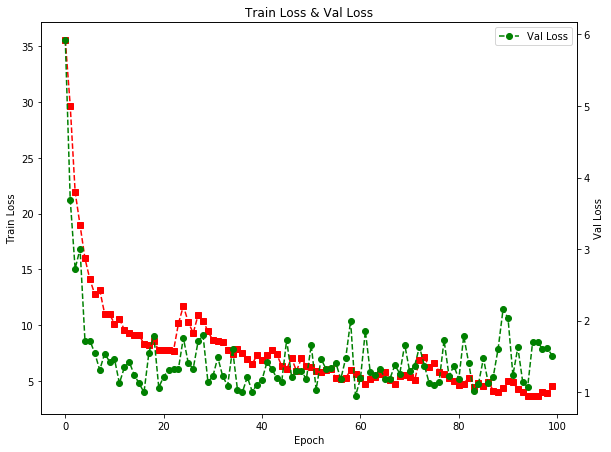

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax0 = plt.subplots(figsize=(9.6,7.2))
ax1 = ax0.twinx()
ax0.set_title("Train Loss & Val Loss")
ax0.plot(all_train_loss, 'rs--', label="Train Loss")
ax0.set_ylabel("Train Loss")
ax0.grid(False)
ax1.plot(all_val_loss, 'go--', label="Val Loss")
ax1.set_ylabel("Val Loss")
ax1.grid(False)
ax0.set_xlabel("Epoch")
plt.legend(loc=1)
plt.show()